In [1]:
# STEP: Recursively unzip any .zip files inside data_dir (handles nested zips)
import os, zipfile

data_dir = "."   # <- change this to your folder if different

def extract_all_zips(root):
    found = False
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            if fname.lower().endswith('.zip'):
                found = True
                zip_path = os.path.join(dirpath, fname)
                target_dir = os.path.join(dirpath, os.path.splitext(fname)[0])
                os.makedirs(target_dir, exist_ok=True)
                print("Extracting:", zip_path, "->", target_dir)
                try:
                    with zipfile.ZipFile(zip_path, 'r') as z:
                        z.extractall(target_dir)
                except Exception as e:
                    print("  Failed to extract", zip_path, ":", e)
    return found

# Run extraction repeatedly until no .zip files remain (or up to 10 loops to be safe)
loops = 0
while loops < 10:
    loops += 1
    more = extract_all_zips(data_dir)
    if not more:
        break

print("Done. Extraction loops:", loops)


Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+performance
Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+performance
Extracting: .\student+performance\student.zip -> .\student+performance\student
Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+performance
Extracting: .\student+performance\student.zip -> .\student+performance\student
Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+performance
Extracting: .\student+performance\student.zip -> .\student+performance\student
Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+performance
Extracting: .\student+performance\student.zip -> .\student+performance\student
Extracting: .\anonymisedData.zip -> .\anonymisedData
Extracting: .\student+performance.zip -> .\student+

In [7]:
!conda install pandas -y

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.7.0




In [10]:
# Run this to list all CSV files under the current folder and preview up to 2 of them

import pandas as pd

root = "."   # change to "data" if you extracted into a data/ folder
csv_paths = []
for dirpath, dirnames, filenames in os.walk(root):
    for fname in filenames:
        if fname.lower().endswith('.csv'):
            csv_paths.append(os.path.join(dirpath, fname))
csv_paths = sorted(csv_paths)

print("Found", len(csv_paths), "CSV files. Showing first 30 paths:")
for p in csv_paths[:30]:
    print(p)

# Preview first two CSV files (first 5 rows each)
for p in csv_paths[:2]:
    print("\n--- Previewing:", p)
    try:
        df = pd.read_csv(p, nrows=5)
        print(df.head())
    except Exception as e:
        print("  Could not read file (error):", e)


Found 9 CSV files. Showing first 30 paths:
.\anonymisedData\assessments.csv
.\anonymisedData\courses.csv
.\anonymisedData\studentAssessment.csv
.\anonymisedData\studentInfo.csv
.\anonymisedData\studentRegistration.csv
.\anonymisedData\studentVle.csv
.\anonymisedData\vle.csv
.\student+performance\student\student-mat.csv
.\student+performance\student\student-por.csv

--- Previewing: .\anonymisedData\assessments.csv
  code_module code_presentation  id_assessment assessment_type  date  weight
0         AAA             2013J           1752             TMA    19      10
1         AAA             2013J           1753             TMA    54      20
2         AAA             2013J           1754             TMA   117      20
3         AAA             2013J           1755             TMA   166      20
4         AAA             2013J           1756             TMA   215      30

--- Previewing: .\anonymisedData\courses.csv
  code_module code_presentation  module_presentation_length
0         AAA  

In [11]:
# Inspect VLE.csv (or fall back to studentvle.csv)
import os, pandas as pd

# find VLE or studentvle automatically from csv_paths
vle_path = None
for p in csv_paths:
    name = os.path.basename(p).lower()
    if name == 'vle.csv' or 'vle.csv' in name:
        vle_path = p; break
if not vle_path:
    for p in csv_paths:
        if 'studentvle' in os.path.basename(p).lower():
            vle_path = p; break

print("Using file:", vle_path)
df = pd.read_csv(vle_path, nrows=10)
print("Preview shape (rows shown):", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(10))

# detect likely timestamp columns
time_cols = [c for c in df.columns if any(k in c.lower() for k in ('date','time','timestamp','ts'))]
print("Detected time-like columns:", time_cols)



Using file: .\anonymisedData\studentVle.csv
Preview shape (rows shown): (10, 6)
Columns: ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click']
  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1
5         AAA             2013J       28400   546652   -10          8
6         AAA             2013J       28400   546876   -10          2
7         AAA             2013J       28400   546688   -10         15
8         AAA             2013J       28400   546662   -10         17
9         AAA             2013J       28400   546890   -10          1
Detected time-like columns: ['date']


In [13]:
# Inspect VLE file columns & sample rows so we can adapt to the real names
import os, pandas as pd

# find a VLE file in csv_paths (uses the csv_paths variable from before)
vle_list = [p for p in csv_paths if os.path.basename(p).lower().startswith('vle')]
if not vle_list:
    vle_list = [p for p in csv_paths if 'vle' in os.path.basename(p).lower()]
if not vle_list:
    raise FileNotFoundError("Couldn't find a VLE file in csv_paths. Print csv_paths and check.")

vle_path = vle_list[0]
print("Using file:", vle_path)
df = pd.read_csv(vle_path, nrows=5)
print("\nColumns:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
display(df)
print("\nDtypes:")
print(df.dtypes)


Using file: .\anonymisedData\vle.csv

Columns:
['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to']

First 5 rows:


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN



Dtypes:
id_site                int64
code_module           object
code_presentation     object
activity_type         object
week_from            float64
week_to              float64
dtype: object


In [14]:
# Inspect studentVle.csv (find and show columns + sample rows)
import os, pandas as pd

# find studentvle file in csv_paths
sv_list = [p for p in csv_paths if os.path.basename(p).lower().startswith('studentvle') or 'studentvle' in os.path.basename(p).lower()]
if not sv_list:
    raise FileNotFoundError("studentVle.csv not found in csv_paths. Print csv_paths to check.")
sv_path = sv_list[0]
print("Using:", sv_path)
df = pd.read_csv(sv_path, nrows=8)
print("Columns:", df.columns.tolist())
print("\nSample rows:")
display(df)
print("\nDtypes:")
print(df.dtypes)


Using: .\anonymisedData\studentVle.csv
Columns: ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click']

Sample rows:


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15



Dtypes:
code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object


In [15]:
# Create workload.csv from studentVle.csv (use courses.csv start dates if available, else fallback)
import os, pandas as pd

root = "./anonymisedData"   # change if your folder is different
sv_path = os.path.join(root, "studentVle.csv")
courses_path = os.path.join(root, "courses.csv")  # we'll look here for a start date if present

# load studentVle (only needed cols)
sv = pd.read_csv(sv_path, usecols=['code_module','code_presentation','id_student','date','sum_click'])
print("studentVle rows:", len(sv))

start_col = None
if os.path.exists(courses_path):
    try:
        courses = pd.read_csv(courses_path)
        # find any column with 'start' or 'date' in the name
        cand = [c for c in courses.columns if any(k in c.lower() for k in ('start','date','begin','presentation'))]
        print("courses.csv candidate date cols:", cand)
        if cand:
            start_col = cand[0]
            courses[start_col] = pd.to_datetime(courses[start_col], errors='coerce')
            # keep only module+presentation+start
            if {'code_module','code_presentation', start_col}.issubset(courses.columns):
                ref = courses[['code_module','code_presentation', start_col]].drop_duplicates()
                sv = sv.merge(ref, on=['code_module','code_presentation'], how='left')
                # if merge failed for most rows, ignore start_col
                if sv[start_col].notna().mean() < 0.05:
                    print("Too few parsed start dates from courses -> falling back.")
                    start_col = None
            else:
                start_col = None
    except Exception as e:
        print("Could not parse courses.csv:", e)
        start_col = None

# create timestamp: either using course start + date days, or fixed fallback
if start_col:
    sv['timestamp'] = sv[start_col] + pd.to_timedelta(sv['date'], unit='D')
    print("Using courses start dates to build timestamps.")
else:
    start0 = pd.to_datetime('2013-01-01')
    sv['timestamp'] = start0 + pd.to_timedelta(sv['date'], unit='D')
    print("Using fallback start date 2013-01-01 for timestamps.")

# convert to seconds since start and make workload (arrivals per second)
sv['sec'] = (sv['timestamp'] - sv['timestamp'].min()).dt.total_seconds().astype(int)
trace = sv.groupby('sec').size().reset_index(name='arrivals').sort_values('sec').reset_index(drop=True)

out_path = os.path.join(root, 'workload.csv')
trace.to_csv(out_path, index=False)
print("Saved workload.csv ->", out_path, "rows:", len(trace))
trace.head()


studentVle rows: 10655280
courses.csv candidate date cols: ['code_presentation', 'module_presentation_length']
Could not parse courses.csv: The column label 'code_presentation' is not unique.


C:\Users\SLEEMTEECH\AppData\Local\Temp\ipykernel_1264\1389594043.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  courses[start_col] = pd.to_datetime(courses[start_col], errors='coerce')


Using fallback start date 2013-01-01 for timestamps.
Saved workload.csv -> ./anonymisedData\workload.csv rows: 295


,sec,arrivals
0,0,4291
1,86400,3887
2,172800,2618
3,259200,1728
4,345600,1283


In [16]:
# Expand workload -> requests and attach UCI demographics (safe sampling)
import os, numpy as np, pandas as pd

root = "./anonymisedData"   # folder with workload.csv and UCI files
work_path = os.path.join(root, "workload.csv")
if not os.path.exists(work_path):
    raise FileNotFoundError("workload.csv not found at " + work_path)

# load workload (sec, arrivals)
work = pd.read_csv(work_path)
total_events = int(work['arrivals'].sum())
print("Total events in workload.csv:", total_events)

# safety cap: scale down proportionally if too large
max_requests = 200000
if total_events > max_requests:
    print(f"Total events ({total_events}) > {max_requests}. Downsampling proportionally.")
    scale = max_requests / total_events
    work['sampled'] = (work['arrivals'] * scale).round().astype(int)
    work.loc[(work['arrivals']>0) & (work['sampled']==0), 'sampled'] = 1
else:
    work['sampled'] = work['arrivals'].astype(int)

print("Total requests after sampling:", int(work['sampled'].sum()))

# Expand sampled counts into per-request seconds, spreading events uniformly within each day
rows = []
for _, r in work.iterrows():
    sec0 = int(r['sec'])
    n = int(r['sampled'])
    if n <= 0:
        continue
    start = sec0
    end = sec0 + 86400
    chosen = np.random.randint(start, end, size=n)
    rows.extend(chosen.tolist())

requests = pd.DataFrame({'sec': rows})
requests = requests.sort_values('sec').reset_index(drop=True)
requests['request_id'] = range(1, len(requests)+1)
print("Expanded requests shape:", requests.shape)

# Find UCI student file automatically
csvs = []
for dirpath, dirnames, filenames in os.walk(root):
    for fname in filenames:
        if fname.lower().startswith('student-mat') or fname.lower().startswith('student-por') or 'student-mat' in fname.lower() or 'student-por' in fname.lower():
            csvs.append(os.path.join(dirpath, fname))
uci_path = csvs[0] if csvs else None
if not uci_path:
    raise FileNotFoundError("No UCI student file (student-mat/por) found under " + root)

# detect delimiter and load UCI
with open(uci_path, 'r', encoding='utf-8', errors='ignore') as f:
    first = f.readline()
sep = ';' if ';' in first else ','
uci = pd.read_csv(uci_path, sep=sep)
print("Loaded UCI:", os.path.basename(uci_path), "shape:", uci.shape)

# select demographic columns (fallback to whatever exists)
keep = ['sex','age','address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','studytime','failures','schoolsup','famsup','internet','G3']
keep_present = [c for c in keep if c in uci.columns]
if not keep_present:
    keep_present = list(uci.columns)
print("UCI columns used for sampling:", keep_present)

# sample demographics WITH replacement to match requests length
sampled = uci[keep_present].sample(n=len(requests), replace=True, random_state=42).reset_index(drop=True)
requests = pd.concat([requests.reset_index(drop=True), sampled.reset_index(drop=True)], axis=1)

# save requests.csv
out = os.path.join(root, 'requests.csv')
requests.to_csv(out, index=False)
print("Saved requests.csv ->", out, "rows:", len(requests))


Total events in workload.csv: 10655280
Total events (10655280) > 200000. Downsampling proportionally.
Total requests after sampling: 199997
Expanded requests shape: (199997, 2)


FileNotFoundError: No UCI student file (student-mat/por) found under ./anonymisedData

In [17]:
# FIXED: find UCI anywhere, attach demographics to existing requests (safe)
import os, pandas as pd

# 1) search workspace for UCI student files
uci_paths = []
for dirpath, dirnames, filenames in os.walk("."):
    for fname in filenames:
        n = fname.lower()
        if n.startswith('student-mat') or n.startswith('student-por') or 'student-mat' in n or 'student-por' in n:
            uci_paths.append(os.path.join(dirpath, fname))
uci_paths = sorted(set(uci_paths))
print("UCI candidates found:", uci_paths)

if not uci_paths:
    raise FileNotFoundError("No UCI student-mat/por files found under notebook folder. Move them into project or provide path.")

# 2) pick the first match (change index if you want the other file)
uci_path = uci_paths[0]
print("Using UCI file:", uci_path)

# 3) read UCI (auto-detect ; or ,)
with open(uci_path, 'r', encoding='utf-8', errors='ignore') as f:
    first = f.readline()
sep = ';' if ';' in first else ','
uci = pd.read_csv(uci_path, sep=sep)
print("Loaded UCI shape:", uci.shape)

# 4) columns we'll try to use (fallback to all present columns)
keep = ['sex','age','address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','studytime','failures','schoolsup','famsup','internet','G3']
keep_present = [c for c in keep if c in uci.columns]
if not keep_present:
    keep_present = list(uci.columns)
print("Columns used for sampling:", keep_present)

# 5) ensure 'requests' DataFrame exists (from previous expansion) or load requests_oulad.csv
if 'requests' not in globals():
    cand_paths = ['./anonymisedData/requests_oulad.csv', './requests_oulad.csv', './anonymisedData/requests.csv', './requests.csv']
    found = None
    for p in cand_paths:
        if os.path.exists(p):
            found = p; break
    if found:
        requests = pd.read_csv(found)
        print("Loaded requests from:", found, "shape:", requests.shape)
    else:
        raise NameError("`requests` not in memory and no requests_oulad.csv found. Re-run expansion step first.")

# 6) attach sampled demographics (with replacement) and save
sampled = uci[keep_present].sample(n=len(requests), replace=True, random_state=42).reset_index(drop=True)
requests = requests.reset_index(drop=True).copy()
requests = pd.concat([requests, sampled], axis=1)

out = './anonymisedData/requests.csv'
os.makedirs(os.path.dirname(out), exist_ok=True)
requests.to_csv(out, index=False)
print("Saved final requests.csv ->", out, "rows:", len(requests))


UCI candidates found: ['.\\student+performance\\student\\student-mat.csv', '.\\student+performance\\student\\student-por.csv']
Using UCI file: .\student+performance\student\student-mat.csv
Loaded UCI shape: (395, 33)
Columns used for sampling: ['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'studytime', 'failures', 'schoolsup', 'famsup', 'internet', 'G3']
Saved final requests.csv -> ./anonymisedData/requests.csv rows: 199997


In [18]:
# Simulator skeleton + two baseline schedulers (random & round-robin)
import os, math, numpy as np, pandas as pd, random, time
from statistics import mean
random.seed(1)
np.random.seed(1)

# --------- Config (change these if you want) ----------
REQUESTS_PATH = './anonymisedData/requests.csv'   # input produced earlier
OUT_DIR = './anonymisedData/sim_results'
os.makedirs(OUT_DIR, exist_ok=True)

NUM_SERVERS = 6            # number of fog nodes / servers to simulate
BASE_SERVICE = 0.8         # base service time in seconds (deterministic part)
SERVICE_EXP_SCALE = 0.5    # exponential jitter scale (so service_time = BASE + Exp(scale))
SLA_SECONDS = 2.0          # SLA threshold in seconds (for % violations)
MAX_EVENTS = None          # set to an int to limit processed requests for quick tests

# --------- Helper classes / schedulers ----------
class Server:
    def __init__(self, sid):
        self.id = sid
        self.next_free = 0.0   # next time (seconds) when server is free

def random_scheduler(request_row, servers, state):
    """Choose a server uniformly at random."""
    return random.randrange(len(servers))

def make_round_robin():
    idx = {'i': 0}
    def rr(request_row, servers, state):
        i = idx['i'] % len(servers)
        idx['i'] += 1
        return i
    return rr

# --------- Core simulator ----------
def run_simulator(scheduler_fn, sim_name='sim', num_servers=NUM_SERVERS,
                  base_service=BASE_SERVICE, exp_scale=SERVICE_EXP_SCALE, sla=SLA_SECONDS,
                  max_events=MAX_EVENTS):
    # load requests
    reqs = pd.read_csv(REQUESTS_PATH)
    reqs = reqs.sort_values('sec').reset_index(drop=True)
    if max_events:
        reqs = reqs.iloc[:max_events].copy()
    # convert sec -> float arrival time (seconds)
    reqs['arrival'] = reqs['sec'].astype(float)

    # init servers
    servers = [Server(i) for i in range(num_servers)]

    # storage for results
    results = []
    state = {}  # scheduler state (if needed)

    t0 = time.time()
    for idx, row in reqs.iterrows():
        arrival = float(row['arrival'])
        # pick server
        sid = scheduler_fn(row, servers, state)
        server = servers[sid]

        # sample service time (BASE + exponential jitter)
        service_time = base_service + np.random.exponential(scale=exp_scale)

        # when service starts is either arrival or when server becomes free
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival

        # update server availability
        server.next_free = finish

        # store per-request info
        rec = {
            'request_idx': int(idx),
            'arrival': arrival,
            'server_id': sid,
            'start': start,
            'finish': finish,
            'service_time': service_time,
            'response_time': response_time
        }
        results.append(rec)

    duration = time.time() - t0
    df = pd.DataFrame(results)
    # metrics
    avg_rt = df['response_time'].mean()
    p95 = df['response_time'].quantile(0.95)
    throughput = len(df) / ( (df['finish'].max() - df['arrival'].min()) if len(df)>0 else 1 )
    sla_viol = (df['response_time'] > sla).mean() * 100.0

    # per-server load stats
    server_loads = df.groupby('server_id')['service_time'].sum().to_dict()
    loads = [server_loads.get(i, 0.0) for i in range(num_servers)]

    # save results
    out_csv = os.path.join(OUT_DIR, f'{sim_name}_results.csv')
    df.to_csv(out_csv, index=False)

    # print summary
    print(f"Simulator: {sim_name}  | servers: {num_servers} | requests: {len(df)}")
    print(f" Time to simulate (wall): {duration:.2f}s")
    print(f" Avg response time: {avg_rt:.3f} s | 95th pct: {p95:.3f} s | Throughput: {throughput:.3f} req/s")
    print(f" % SLA (> {sla}s): {sla_viol:.2f}%")
    print(" Server total busy-time (s):", [round(x,2) for x in loads])
    print(" Saved per-request results to:", out_csv)
    return df, {
        'avg_rt': avg_rt, 'p95': p95, 'throughput': throughput,
        'sla_viol_pct': sla_viol, 'server_loads': loads
    }

# --------- Run baselines ----------
print("Loading requests from:", REQUESTS_PATH)
print("Running baselines... (this may take a moment)")

# Random baseline
df_rand, stats_rand = run_simulator(random_scheduler, sim_name='baseline_random', num_servers=NUM_SERVERS)

# Round-robin baseline
rr_fn = make_round_robin()
df_rr, stats_rr = run_simulator(rr_fn, sim_name='baseline_roundrobin', num_servers=NUM_SERVERS)

# Save summary comparison
summary = pd.DataFrame({
    'policy': ['random', 'round-robin'],
    'avg_rt_s': [stats_rand['avg_rt'], stats_rr['avg_rt']],
    'p95_s': [stats_rand['p95'], stats_rr['p95']],
    'throughput_rps': [stats_rand['throughput'], stats_rr['throughput']],
    'sla_viol_pct': [stats_rand['sla_viol_pct'], stats_rr['sla_viol_pct']]
})
summary_path = os.path.join(OUT_DIR, 'baseline_summary.csv')
summary.to_csv(summary_path, index=False)
print("Saved baseline summary to:", summary_path)
print("\nBaseline summary:\n", summary)


Loading requests from: ./anonymisedData/requests.csv
Running baselines... (this may take a moment)
Simulator: baseline_random  | servers: 6 | requests: 199997
 Time to simulate (wall): 33.81s
 Avg response time: 1.301 s | 95th pct: 2.306 s | Throughput: 0.008 req/s
 % SLA (> 2.0s): 9.16%
 Server total busy-time (s): [43384.67, 43577.44, 42877.65, 43547.57, 43400.36, 43088.39]
 Saved per-request results to: ./anonymisedData/sim_results\baseline_random_results.csv
Simulator: baseline_roundrobin  | servers: 6 | requests: 199997
 Time to simulate (wall): 32.23s
 Avg response time: 1.300 s | 95th pct: 2.298 s | Throughput: 0.008 req/s
 % SLA (> 2.0s): 9.03%
 Server total busy-time (s): [43365.91, 43449.92, 43235.82, 43290.25, 43358.1, 43279.08]
 Saved per-request results to: ./anonymisedData/sim_results\baseline_roundrobin_results.csv
Saved baseline summary to: ./anonymisedData/sim_results\baseline_summary.csv

Baseline summary:
         policy  avg_rt_s     p95_s  throughput_rps  sla_viol_

In [20]:
# Modified Hierarchical tabular Q-learning scheduler (with wait-penalty + imbalance state)
import os, math, random, time
import numpy as np, pandas as pd
from collections import defaultdict
random.seed(123); np.random.seed(123)

REQUESTS_PATH = './anonymisedData/requests.csv'
OUT_DIR = './anonymisedData/sim_results'
os.makedirs(OUT_DIR, exist_ok=True)

# Simulation parameters (tweak)
NUM_SERVERS = 6
GROUPS = 2                        # high-level chooses group index 0..GROUPS-1 (simple split)
SERVERS_PER_GROUP = NUM_SERVERS // GROUPS
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA_SECONDS = 2.0

# Q-learning hyperparams (tune these if needed)
ALPHA = 0.1
GAMMA = 0.8
EPS_START = 0.9
EPS_MIN = 0.1
EPS_DECAY = 0.995

EPISODES = 10                     # reduce to 2-3 for a quick test
max_train_requests = 50000        # set smaller for faster training; must be <= total requests

# Discretization helpers (make state small for tabular Q)
def bucket_load(load, bins=(0,5,10,20,50,100,999999)):
    # load in seconds -> bucket index
    for i,b in enumerate(bins):
        if load <= b:
            return i
    return len(bins)

def make_state(servers, arrival_rate_bucket=0):
    """
    NEW: enriched state includes imbalance bucket
    state = (avg_load_bucket, imbalance_bucket)
    imbalance = floor((max_load - avg_load) / 10) clipped to 0..9
    """
    loads = [s.next_free for s in servers]
    avg_load = sum(loads)/len(loads) if loads else 0.0
    max_load = max(loads) if loads else 0.0
    imbalance = int((max_load - avg_load) // 10)
    if imbalance < 0:
        imbalance = 0
    if imbalance > 9:
        imbalance = 9
    return (bucket_load(avg_load), imbalance)

# Simple environment (similar to previous simulator)
class Server:
    def __init__(self, sid):
        self.id = sid
        self.next_free = 0.0

def reset_servers(num_servers):
    return [Server(i) for i in range(num_servers)]

def sample_service_time():
    return BASE_SERVICE + np.random.exponential(SERVICE_EXP_SCALE)

# Hierarchical Q structures (re-initialize before training)
def make_Q_structures():
    Q_high = defaultdict(lambda: np.zeros(GROUPS))   # maps state -> vector of group-values
    Q_low = defaultdict(lambda: np.zeros(SERVERS_PER_GROUP))  # maps (state,group) -> vector for servers in that group
    return Q_high, Q_low

def choose_action_hierarchical(state, servers, eps, Q_high, Q_low):
    # high-level: pick group via epsilon-greedy on Q_high[state]
    qh = Q_high[state]
    if random.random() < eps:
        group = random.randrange(GROUPS)
    else:
        group = int(np.argmax(qh))
    # low-level: pick server index within group
    ql = Q_low[(state, group)]
    if random.random() < eps:
        choice = random.randrange(SERVERS_PER_GROUP)
    else:
        choice = int(np.argmax(ql))
    # map to global server id
    server_id = group*SERVERS_PER_GROUP + choice
    if server_id >= NUM_SERVERS:  # safety if split uneven
        server_id = NUM_SERVERS-1
    return group, choice, server_id

# single-episode run that also performs online Q updates (returns avg reward)
def run_episode_and_train(requests_df, eps, Q_high, Q_low, alpha=ALPHA, gamma=GAMMA):
    servers = reset_servers(NUM_SERVERS)
    total_reward = 0.0
    steps = 0
    for idx, row in requests_df.iterrows():
        arrival = float(row['sec'])
        # state before action
        state = make_state(servers, arrival_rate_bucket=0)
        group, low_choice, sid = choose_action_hierarchical(state, servers, eps, Q_high, Q_low)
        server = servers[sid]
        service_time = sample_service_time()
        # compute wait and reward (NEW: include wait penalty)
        wait = max(0.0, server.next_free - arrival)                        # seconds waiting before service
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival
        reward = -response_time - 0.0001*service_time - 0.01 * wait        # heavier penalty for wait
        total_reward += reward
        steps += 1
        # update server
        server.next_free = finish
        # next state
        next_state = make_state(servers, arrival_rate_bucket=0)
        # ----- Q updates (hierarchical) -----
        # high-level update
        qh = Q_high[state]
        best_next_high = np.max(Q_high[next_state]) if next_state in Q_high else 0.0
        td_high = (reward + gamma*best_next_high) - qh[group]
        qh[group] += alpha * td_high
        Q_high[state] = qh
        # low-level update for (state, group)
        ql = Q_low[(state, group)]
        best_next_low = np.max(Q_low[(next_state, group)]) if (next_state, group) in Q_low else 0.0
        td_low = (reward + gamma*best_next_low) - ql[low_choice]
        ql[low_choice] += alpha * td_low
        Q_low[(state, group)] = ql
    avg_reward = total_reward / max(1, steps)
    return avg_reward

# ---- Load requests (chronological) and prepare training subset ----
reqs = pd.read_csv(REQUESTS_PATH)
reqs = reqs.sort_values('sec').reset_index(drop=True)
total_reqs = len(reqs)
print("Total requests available:", total_reqs)
train_n = min(max_train_requests, total_reqs)
train_df = reqs.iloc[:train_n].copy()
print("Training on:", len(train_df), "requests per episode")

# ---- Initialize Q structures and training loop ----
Q_high, Q_low = make_Q_structures()
eps = EPS_START
train_rewards = []
t0 = time.time()
for ep in range(1, EPISODES+1):
    avg_r = run_episode_and_train(train_df, eps, Q_high, Q_low, alpha=ALPHA, gamma=GAMMA)
    train_rewards.append(avg_r)
    eps = max(EPS_MIN, eps * EPS_DECAY)
    print(f"Episode {ep}/{EPISODES}  avg_reward={avg_r:.4f}  eps={eps:.3f}")
elapsed = time.time() - t0
print("Training finished in", round(elapsed,2), "s")

# ---- Evaluation using learned policy (greedy) ----
def eval_with_policy(requests_df, Q_high, Q_low):
    servers = reset_servers(NUM_SERVERS)
    results = []
    for idx, row in requests_df.iterrows():
        arrival = float(row['sec'])
        state = make_state(servers, 0)
        # greedy high-level
        group = int(np.argmax(Q_high[state])) if state in Q_high else random.randrange(GROUPS)
        ql = Q_low[(state, group)]
        low_choice = int(np.argmax(ql)) if (state,group) in Q_low else 0
        sid = group*SERVERS_PER_GROUP + low_choice
        if sid >= NUM_SERVERS:
            sid = NUM_SERVERS-1
        server = servers[sid]
        service_time = sample_service_time()
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival
        server.next_free = finish
        results.append({'arrival': arrival, 'server_id': sid, 'start': start, 'finish': finish, 'response_time': response_time})
    df = pd.DataFrame(results)
    return df

# Evaluate on a held-out set (here use full requests for evaluation)
eval_df = reqs.copy()
df_rl = eval_with_policy(eval_df, Q_high, Q_low)

# compute metrics (same as baseline)
avg_rt = df_rl['response_time'].mean()
p95 = df_rl['response_time'].quantile(0.95)
throughput = len(df_rl) / ((df_rl['finish'].max() - df_rl['arrival'].min()) if len(df_rl)>0 else 1)
sla_viol = (df_rl['response_time'] > SLA_SECONDS).mean() * 100.0
server_loads = df_rl.groupby('server_id')['response_time'].sum().to_dict()
loads = [server_loads.get(i, 0.0) for i in range(NUM_SERVERS)]

# save results and print
out_csv = os.path.join(OUT_DIR, 'rl_policy_results.csv')
df_rl.to_csv(out_csv, index=False)
print("\nRL evaluation results:")
print(f" Avg RT: {avg_rt:.3f} s  | 95th: {p95:.3f} s | Throughput: {throughput:.3f} req/s | SLA%: {sla_viol:.2f}%")
print(" Server loads (s):", [round(x,2) for x in loads])
print("Saved RL per-request results to:", out_csv)

# Save a short summary comparing baselines vs RL (if baseline_summary exists, load and append)
bsum_path = os.path.join(OUT_DIR, 'baseline_summary.csv')
summary_rows = []
if os.path.exists(bsum_path):
    bsum = pd.read_csv(bsum_path)
    print("Loaded baseline summary for comparison.")
    for _, r in bsum.iterrows():
        summary_rows.append(r.to_dict())
summary_rows.append({'policy':'rl_hier', 'avg_rt_s': avg_rt, 'p95_s': p95, 'throughput_rps': throughput, 'sla_viol_pct': sla_viol})
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(os.path.join(OUT_DIR, 'comparison_summary.csv'), index=False)
print("\nComparison summary saved to:", os.path.join(OUT_DIR, 'comparison_summary.csv'))


Total requests available: 199997
Training on: 50000 requests per episode
Episode 1/10  avg_reward=-1.3031  eps=0.895
Episode 2/10  avg_reward=-1.3018  eps=0.891
Episode 3/10  avg_reward=-1.3016  eps=0.887
Episode 4/10  avg_reward=-1.3054  eps=0.882
Episode 5/10  avg_reward=-1.3040  eps=0.878
Episode 6/10  avg_reward=-1.3009  eps=0.873
Episode 7/10  avg_reward=-1.3045  eps=0.869
Episode 8/10  avg_reward=-1.3020  eps=0.865
Episode 9/10  avg_reward=-1.3056  eps=0.860
Episode 10/10  avg_reward=-1.2993  eps=0.856
Training finished in 73.22 s

RL evaluation results:
 Avg RT: 1.310 s  | 95th: 2.333 s | Throughput: 0.008 req/s | SLA%: 9.57%
 Server loads (s): [0.0, 90613.1, 0.0, 0.0, 1.05, 171477.12]
Saved RL per-request results to: ./anonymisedData/sim_results\rl_policy_results.csv
Loaded baseline summary for comparison.

Comparison summary saved to: ./anonymisedData/sim_results\comparison_summary.csv


In [21]:
# QUICK TUNING SWEEP: vary wait_penalty, alpha, gamma (fast tests)
import os, time, random
import numpy as np, pandas as pd
from collections import defaultdict
random.seed(1); np.random.seed(1)

REQUESTS_PATH = './anonymisedData/requests.csv'
OUT_DIR = './anonymisedData/sim_results'
os.makedirs(OUT_DIR, exist_ok=True)

NUM_SERVERS = 6
GROUPS = 2
SERVERS_PER_GROUP = NUM_SERVERS // GROUPS
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA_SECONDS = 2.0

# fast training settings
EPISODES = 6
train_n = 20000
eval_n = 30000

# small grid
WAIT_PENALTIES = [0.01, 0.05, 0.1]
ALPHAS = [0.05, 0.1]
GAMMAS = [0.8, 0.95]

# helpers (simple, similar to your previous code)
def bucket_load(load, bins=(0,5,10,20,50,100,999999)):
    for i,b in enumerate(bins):
        if load <= b:
            return i
    return len(bins)

class Server:
    def __init__(self, sid):
        self.id = sid
        self.next_free = 0.0

def reset_servers(num_servers):
    return [Server(i) for i in range(num_servers)]

def sample_service_time():
    return BASE_SERVICE + np.random.exponential(SERVICE_EXP_SCALE)

def make_state(servers):
    loads = [s.next_free for s in servers]
    avg_load = sum(loads)/len(loads) if loads else 0.0
    max_load = max(loads) if loads else 0.0
    imbalance = int(min(9, (max_load - avg_load)//10))
    return (bucket_load(avg_load), imbalance)

def train_config(alpha, gamma, wait_penalty, episodes, train_df):
    # init Q
    Q_high = defaultdict(lambda: np.zeros(GROUPS))
    Q_low = defaultdict(lambda: np.zeros(SERVERS_PER_GROUP))
    eps = 0.9
    eps_min = 0.1
    eps_decay = 0.995
    for ep in range(episodes):
        servers = reset_servers(NUM_SERVERS)
        for _, row in train_df.iterrows():
            arrival = float(row['sec'])
            state = make_state(servers)
            # choose actions (epsilon-greedy)
            if random.random() < eps:
                group = random.randrange(GROUPS)
            else:
                group = int(np.argmax(Q_high[state]))
            if random.random() < eps:
                low_choice = random.randrange(SERVERS_PER_GROUP)
            else:
                low_choice = int(np.argmax(Q_low[(state, group)]))
            sid = group*SERVERS_PER_GROUP + low_choice
            if sid >= NUM_SERVERS: sid = NUM_SERVERS-1
            server = servers[sid]
            service_time = sample_service_time()
            wait = max(0.0, server.next_free - arrival)
            start = max(arrival, server.next_free)
            finish = start + service_time
            response_time = finish - arrival
            reward = -response_time - 0.0001*service_time - wait_penalty * wait
            # update server
            server.next_free = finish
            next_state = make_state(servers)
            # high update
            qh = Q_high[state]
            best_next_h = np.max(Q_high[next_state]) if next_state in Q_high else 0.0
            td_h = (reward + gamma*best_next_h) - qh[group]
            qh[group] += alpha * td_h
            Q_high[state] = qh
            # low update
            ql = Q_low[(state, group)]
            best_next_l = np.max(Q_low[(next_state, group)]) if (next_state, group) in Q_low else 0.0
            td_l = (reward + gamma*best_next_l) - ql[low_choice]
            ql[low_choice] += alpha * td_l
            Q_low[(state, group)] = ql
        eps = max(eps_min, eps * eps_decay)
    return Q_high, Q_low

def eval_policy(Q_high, Q_low, eval_df):
    servers = reset_servers(NUM_SERVERS)
    res = []
    for _, row in eval_df.iterrows():
        arrival = float(row['sec'])
        state = make_state(servers)
        group = int(np.argmax(Q_high[state])) if state in Q_high else random.randrange(GROUPS)
        low_choice = int(np.argmax(Q_low[(state, group)])) if (state,group) in Q_low else 0
        sid = group*SERVERS_PER_GROUP + low_choice
        if sid >= NUM_SERVERS: sid = NUM_SERVERS-1
        server = servers[sid]
        service_time = sample_service_time()
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival
        server.next_free = finish
        res.append(response_time)
    arr = np.array(res)
    return arr.mean(), np.percentile(arr,95), (arr> SLA_SECONDS).mean()*100.0

# prepare data slices
reqs = pd.read_csv(REQUESTS_PATH).sort_values('sec').reset_index(drop=True)
train_df = reqs.iloc[:train_n].copy()
eval_df = reqs.iloc[train_n: train_n + eval_n].copy()

results = []
start_all = time.time()
for wp in WAIT_PENALTIES:
    for a in ALPHAS:
        for g in GAMMAS:
            t0 = time.time()
            Qh, Ql = train_config(a,g, wp, EPISODES, train_df)
            avg_rt, p95, sla = eval_policy(Qh, Ql, eval_df)
            elapsed = time.time() - t0
            results.append({'wait_penalty':wp, 'alpha':a, 'gamma':g, 'avg_rt':avg_rt, 'p95':p95, 'sla_pct':sla, 'time_s':elapsed})
            print(f"wp={wp} a={a} g={g} -> avg_rt={avg_rt:.3f} p95={p95:.3f} sla%={sla:.2f} (t={elapsed:.1f}s)")
            pd.DataFrame(results).to_csv(os.path.join(OUT_DIR, 'tuning_results.csv'), index=False)
print("Grid done in", round(time.time()-start_all,1),"s")
print("Saved tuning_results.csv ->", os.path.join(OUT_DIR, 'tuning_results.csv'))


wp=0.01 a=0.05 g=0.8 -> avg_rt=1.315 p95=2.367 sla%=9.73 (t=20.2s)
wp=0.01 a=0.05 g=0.95 -> avg_rt=1.317 p95=2.372 sla%=9.76 (t=20.6s)
wp=0.01 a=0.1 g=0.8 -> avg_rt=1.319 p95=2.387 sla%=10.01 (t=21.1s)
wp=0.01 a=0.1 g=0.95 -> avg_rt=1.317 p95=2.373 sla%=9.97 (t=20.6s)
wp=0.05 a=0.05 g=0.8 -> avg_rt=1.316 p95=2.351 sla%=9.86 (t=20.0s)
wp=0.05 a=0.05 g=0.95 -> avg_rt=1.318 p95=2.352 sla%=9.87 (t=20.7s)
wp=0.05 a=0.1 g=0.8 -> avg_rt=1.315 p95=2.353 sla%=9.80 (t=20.6s)
wp=0.05 a=0.1 g=0.95 -> avg_rt=1.319 p95=2.375 sla%=10.06 (t=19.9s)
wp=0.1 a=0.05 g=0.8 -> avg_rt=1.319 p95=2.361 sla%=10.06 (t=20.6s)
wp=0.1 a=0.05 g=0.95 -> avg_rt=1.313 p95=2.344 sla%=9.76 (t=20.2s)
wp=0.1 a=0.1 g=0.8 -> avg_rt=1.322 p95=2.370 sla%=10.05 (t=20.7s)
wp=0.1 a=0.1 g=0.95 -> avg_rt=1.323 p95=2.393 sla%=10.31 (t=20.0s)
Grid done in 245.2 s
Saved tuning_results.csv -> ./anonymisedData/sim_results\tuning_results.csv


In [24]:
# Least-Loaded (greedy) scheduler baseline — run and compare to earlier baselines
import os, time, numpy as np, pandas as pd
from statistics import mean

REQUESTS_PATH = './anonymisedData/requests.csv'
OUT_DIR = './anonymisedData/sim_results'
os.makedirs(OUT_DIR, exist_ok=True)

NUM_SERVERS = 6
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA_SECONDS = 2.0

class Server:
    def __init__(self, sid):
        self.id = sid
        self.next_free = 0.0

def sample_service_time():
    return BASE_SERVICE + np.random.exponential(SERVICE_EXP_SCALE)

def run_least_loaded(num_servers=NUM_SERVERS):
    reqs = pd.read_csv(REQUESTS_PATH).sort_values('sec').reset_index(drop=True)
    reqs['arrival'] = reqs['sec'].astype(float)
    servers = [Server(i) for i in range(num_servers)]
    results = []
    t0 = time.time()
    for idx, row in reqs.iterrows():
        arrival = float(row['arrival'])
        # choose server with smallest next_free (least loaded)
        sid = int(min(range(len(servers)), key=lambda i: servers[i].next_free))
        server = servers[sid]
        service_time = sample_service_time()
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival
        server.next_free = finish
        results.append({'request_idx': int(idx), 'arrival': arrival, 'server_id': sid,
                        'start': start, 'finish': finish, 'service_time': service_time,
                        'response_time': response_time})
    duration = time.time() - t0
    df = pd.DataFrame(results)
    avg_rt = df['response_time'].mean()
    p95 = df['response_time'].quantile(0.95)
    throughput = len(df) / ((df['finish'].max() - df['arrival'].min()) if len(df)>0 else 1)
    sla_viol = (df['response_time'] > SLA_SECONDS).mean() * 100.0
    server_loads = df.groupby('server_id')['service_time'].sum().to_dict()
    loads = [server_loads.get(i, 0.0) for i in range(num_servers)]
    out_csv = os.path.join(OUT_DIR, 'baseline_leastloaded_results.csv')
    df.to_csv(out_csv, index=False)
    print(f"Least-loaded | servers: {num_servers} | requests: {len(df)}")
    print(f" Wall time: {duration:.2f}s")
    print(f" Avg RT: {avg_rt:.3f} s | 95th: {p95:.3f} s | Throughput: {throughput:.3f} req/s")
    print(f" % SLA (> {SLA_SECONDS}s): {sla_viol:.2f}%")
    print(" Server busy-time (s):", [round(x,2) for x in loads])
    print("Saved per-request results to:", out_csv)
    return df, {'avg_rt': avg_rt, 'p95': p95, 'throughput': throughput, 'sla_viol_pct': sla_viol, 'loads': loads}

df_ll, stats_ll = run_least_loaded(NUM_SERVERS)
# append to comparison summary if exists
comp_path = os.path.join(OUT_DIR, 'comparison_summary.csv')
row = {'policy':'least_loaded','avg_rt_s':stats_ll['avg_rt'],'p95_s':stats_ll['p95'],
       'throughput_rps':stats_ll['throughput'],'sla_viol_pct':stats_ll['sla_viol_pct']}
if os.path.exists(comp_path):
    # replace the block that used comp.append(...)
    row_df = pd.DataFrame([row])
    comp = pd.concat([comp, row_df], ignore_index=True)
    comp.to_csv(comp_path, index=False)
    print("Appended least-loaded (pd.concat) to comparison_summary.csv")

else:
    pd.DataFrame([row]).to_csv(comp_path, index=False)
    print("Created comparison_summary.csv with least-loaded")


Least-loaded | servers: 6 | requests: 199997
 Wall time: 20.22s
 Avg RT: 1.299 s | 95th: 2.291 s | Throughput: 0.008 req/s
 % SLA (> 2.0s): 9.02%
 Server busy-time (s): [43234.55, 43339.52, 43240.99, 43227.86, 43290.61, 43410.06]
Saved per-request results to: ./anonymisedData/sim_results\baseline_leastloaded_results.csv
Appended least-loaded (pd.concat) to comparison_summary.csv


In [25]:
# A: Repeat Least-Loaded 5 times (different RNG seeds), save per-run CSVs + summary
import os, time, numpy as np, pandas as pd, random
OUT = './anonymisedData/sim_results'
os.makedirs(OUT, exist_ok=True)

REQUESTS = './anonymisedData/requests.csv'
reqs = pd.read_csv(REQUESTS).sort_values('sec').reset_index(drop=True)
reqs['arrival'] = reqs['sec'].astype(float)

NUM_RUNS = 5
SEEDS = [42, 101, 202, 303, 404]
NUM_SERVERS = 6
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA = 2.0

def do_run(seed, run_idx):
    random.seed(seed)
    np.random.seed(seed)
    servers = [{'id':i,'next_free':0.0} for i in range(NUM_SERVERS)]
    rows = []
    t0 = time.time()
    for idx, row in reqs.iterrows():
        arrival = float(row['arrival'])
        # pick least-loaded server (min next_free)
        sid = min(range(NUM_SERVERS), key=lambda i: servers[i]['next_free'])
        server = servers[sid]
        service_time = BASE_SERVICE + np.random.exponential(SERVICE_EXP_SCALE)
        start = max(arrival, server['next_free'])
        finish = start + service_time
        response_time = finish - arrival
        server['next_free'] = finish
        rows.append({'request_idx': int(idx), 'arrival': arrival, 'server_id': sid,
                     'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time})
    df = pd.DataFrame(rows)
    # metrics
    avg_rt = df['response_time'].mean()
    p95 = df['response_time'].quantile(0.95)
    sla_pct = (df['response_time'] > SLA).mean() * 100.0
    out_file = os.path.join(OUT, f'leastloaded_run_{run_idx+1}.csv')
    df.to_csv(out_file, index=False)
    return {'run': run_idx+1, 'seed': seed, 'avg_rt': avg_rt, 'p95': p95, 'sla_pct': sla_pct, 'rows': len(df)}

summary = []
for i, s in enumerate(SEEDS[:NUM_RUNS]):
    print("Running least-loaded repeat", i+1, "seed", s)
    res = do_run(s, i)
    summary.append(res)
    print(" -> avg_rt:", round(res['avg_rt'],3), "p95:", round(res['p95'],3), "SLA%:", round(res['sla_pct'],3))

summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join(OUT, 'leastloaded_repeats_summary.csv'), index=False)
print("Saved repeats summary to:", os.path.join(OUT, 'leastloaded_repeats_summary.csv'))
print(summary_df)


Running least-loaded repeat 1 seed 42
 -> avg_rt: 1.3 p95: 2.294 SLA%: 9.016
Running least-loaded repeat 2 seed 101
 -> avg_rt: 1.299 p95: 2.286 SLA%: 8.928
Running least-loaded repeat 3 seed 202
 -> avg_rt: 1.299 p95: 2.3 SLA%: 9.018
Running least-loaded repeat 4 seed 303
 -> avg_rt: 1.299 p95: 2.292 SLA%: 8.984
Running least-loaded repeat 5 seed 404
 -> avg_rt: 1.3 p95: 2.301 SLA%: 9.047
Saved repeats summary to: ./anonymisedData/sim_results\leastloaded_repeats_summary.csv
   run  seed    avg_rt       p95   sla_pct    rows
0    1    42  1.300144  2.294482  9.015635  199997
1    2   101  1.299309  2.285923  8.927634  199997
2    3   202  1.298985  2.300488  9.018135  199997
3    4   303  1.298751  2.291770  8.983635  199997
4    5   404  1.299732  2.301431  9.046636  199997


In [26]:
# Full RL repeated runs (strong training, 5 seeds) — copy & run as one cell
import os, time, random
import numpy as np, pandas as pd
from collections import defaultdict

# --- Paths
ROOT = './anonymisedData'
REQ_PATH = os.path.join(ROOT, 'requests.csv')
OUT = os.path.join(ROOT, 'sim_results')
os.makedirs(OUT, exist_ok=True)

# --- RL / env hyperparameters (recommended strong settings)
NUM_SERVERS = 6
GROUPS = 2
SERVERS_PER_GROUP = NUM_SERVERS // GROUPS
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA_SECONDS = 2.0

ALPHA = 0.03
GAMMA = 0.99
EPS_START = 0.95
EPS_MIN = 0.05
EPS_DECAY = 0.999

EPISODES = 60            # strong training
TRAIN_N = 100_000        # number training requests per episode
SEEDS = [42, 101, 202, 303, 404]   # independent repeats
WAIT_PENALTY = 0.2       # strong wait penalty
SAVE_PREFIX = 'rl_full'  # output prefix

# --- Helpers
def bucket_load(load, bins=(0,5,10,20,50,100,999999)):
    for i,b in enumerate(bins):
        if load <= b:
            return i
    return len(bins)

class Server:
    def __init__(self, sid):
        self.id = sid
        self.next_free = 0.0

def reset_servers(num_servers):
    return [Server(i) for i in range(num_servers)]

def sample_service_time(rng):
    return BASE_SERVICE + rng.exponential(SERVICE_EXP_SCALE)

def make_state(servers, last_assigned_mod=0):
    loads = [s.next_free for s in servers]
    avg_load = sum(loads)/len(loads) if loads else 0.0
    max_load = max(loads) if loads else 0.0
    imbalance = int(min(9, max(0, (max_load - avg_load)//10)))
    # group average coarse bucket (group 0)
    group_avgs = []
    for g in range(GROUPS):
        group_ids = list(range(g*SERVERS_PER_GROUP, min(NUM_SERVERS, (g+1)*SERVERS_PER_GROUP)))
        gavg = sum(loads[i] for i in group_ids)/len(group_ids)
        group_avgs.append(bucket_load(gavg))
    # state = (avg_bucket, imbalance_bucket, group0_bucket, last_assigned_mod)
    return (bucket_load(avg_load), imbalance, group_avgs[0], int(last_assigned_mod))

# --- Q helpers
def make_Q():
    Qh = defaultdict(lambda: np.zeros(GROUPS))
    Ql = defaultdict(lambda: np.zeros(SERVERS_PER_GROUP))
    return Qh, Ql

def choose_action_eps_greedy(state, Qh, Ql, eps, rng):
    # high-level
    if rng.random() < eps:
        group = rng.integers(0, GROUPS)
    else:
        group = int(np.argmax(Qh[state]))
    # low-level
    if rng.random() < eps:
        low_choice = rng.integers(0, SERVERS_PER_GROUP)
    else:
        low_choice = int(np.argmax(Ql[(state, group)]))
    sid = group*SERVERS_PER_GROUP + low_choice
    if sid >= NUM_SERVERS:
        sid = NUM_SERVERS-1
    return group, low_choice, sid

# --- Load requests and create train/eval splits
reqs = pd.read_csv(REQ_PATH).sort_values('sec').reset_index(drop=True)
total_reqs = len(reqs)
train_n = min(TRAIN_N, total_reqs)
train_df = reqs.iloc[:train_n].copy()
eval_df = reqs.iloc[train_n:].copy()
print("Total requests:", total_reqs, "| training per episode:", len(train_df), "| eval:", len(eval_df))

# --- Main repeated-run loop
summary_rows = []
for seed in SEEDS:
    print("\n=== RL run seed", seed, "===")
    rng = np.random.default_rng(seed)
    random.seed(seed)
    np.random.seed(seed)
    Q_high, Q_low = make_Q()
    eps = EPS_START
    last_assigned = 0

    # training
    tstart = time.time()
    per_episode_rewards = []
    for ep in range(1, EPISODES+1):
        servers = reset_servers(NUM_SERVERS)
        total_reward = 0.0
        steps = 0
        for _, row in train_df.iterrows():
            arrival = float(row['sec'])
            state = make_state(servers, last_assigned_mod=(last_assigned % SERVERS_PER_GROUP))
            group, low_choice, sid = choose_action_eps_greedy(state, Q_high, Q_low, eps, rng)
            # sample service
            service_time = sample_service_time(rng)
            server = servers[sid]
            wait = max(0.0, server.next_free - arrival)
            start = max(arrival, server.next_free)
            finish = start + service_time
            response_time = finish - arrival
            # reward with wait penalty
            reward = -response_time - 0.0001*service_time - WAIT_PENALTY * wait
            total_reward += reward
            steps += 1
            # update server
            server.next_free = finish
            last_assigned = sid
            next_state = make_state(servers, last_assigned_mod=(last_assigned % SERVERS_PER_GROUP))
            # Q updates
            qh = Q_high[state]
            best_next_h = np.max(Q_high[next_state]) if next_state in Q_high else 0.0
            td_h = (reward + GAMMA * best_next_h) - qh[group]
            qh[group] += ALPHA * td_h
            Q_high[state] = qh
            ql = Q_low[(state, group)]
            best_next_l = np.max(Q_low[(next_state, group)]) if (next_state, group) in Q_low else 0.0
            td_l = (reward + GAMMA * best_next_l) - ql[low_choice]
            ql[low_choice] += ALPHA * td_l
            Q_low[(state, group)] = ql
        per_episode_rewards.append(total_reward / max(1, steps))
        eps = max(EPS_MIN, eps * EPS_DECAY)
        if ep % 10 == 0 or ep == 1 or ep == EPISODES:
            print(f"  Ep {ep}/{EPISODES} avg_reward={per_episode_rewards[-1]:.4f} eps={eps:.4f}")
    ttrain = time.time() - tstart
    # save per-episode rewards
    pd.DataFrame({'episode': list(range(1, EPISODES+1)), 'avg_reward': per_episode_rewards}).to_csv(
        os.path.join(OUT, f'{SAVE_PREFIX}_rewards_seed_{seed}.csv'), index=False)

    # evaluation (greedy)
    servers = reset_servers(NUM_SERVERS)
    last_assigned = 0
    rows = []
    for idx, row in eval_df.iterrows():
        arrival = float(row['sec'])
        state = make_state(servers, last_assigned_mod=(last_assigned % SERVERS_PER_GROUP))
        # greedy selection
        if state in Q_high:
            group = int(np.argmax(Q_high[state]))
        else:
            group = rng.integers(0, GROUPS)
        if (state, group) in Q_low:
            low_choice = int(np.argmax(Q_low[(state, group)]))
        else:
            low_choice = 0
        sid = group*SERVERS_PER_GROUP + low_choice
        if sid >= NUM_SERVERS: sid = NUM_SERVERS-1
        server = servers[sid]
        service_time = sample_service_time(rng)
        start = max(arrival, server.next_free)
        finish = start + service_time
        response_time = finish - arrival
        server.next_free = finish
        last_assigned = sid
        rows.append({'request_idx': int(train_n + idx), 'arrival': arrival, 'server_id': sid,
                     'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time})
    df_eval = pd.DataFrame(rows)
    out_eval = os.path.join(OUT, f'{SAVE_PREFIX}_eval_seed_{seed}.csv')
    df_eval.to_csv(out_eval, index=False)

    # metrics
    avg_rt = df_eval['response_time'].mean()
    p95 = df_eval['response_time'].quantile(0.95)
    sla_pct = (df_eval['response_time'] > SLA_SECONDS).mean() * 100.0
    summary_rows.append({'seed': seed, 'avg_rt': avg_rt, 'p95': p95, 'sla_pct': sla_pct, 'train_time_s': ttrain, 'eval_rows': len(df_eval), 'eval_file': out_eval})
    print(f" -> eval avg_rt={avg_rt:.3f} p95={p95:.3f} sla%={sla_pct:.3f}  (saved {out_eval})")

# --- Save overall summary
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(os.path.join(OUT, f'{SAVE_PREFIX}_summary.csv'), index=False)
print("\nSaved per-seed summary to:", os.path.join(OUT, f'{SAVE_PREFIX}_summary.csv'))
print(summary_df)


Total requests: 199997 | training per episode: 100000 | eval: 99997

=== RL run seed 42 ===
  Ep 1/60 avg_reward=-1.3038 eps=0.9490
  Ep 10/60 avg_reward=-1.3035 eps=0.9405
  Ep 20/60 avg_reward=-1.3039 eps=0.9312
  Ep 30/60 avg_reward=-1.3040 eps=0.9219
  Ep 40/60 avg_reward=-1.3036 eps=0.9127
  Ep 50/60 avg_reward=-1.3019 eps=0.9036
  Ep 60/60 avg_reward=-1.3037 eps=0.8946
 -> eval avg_rt=1.309 p95=2.324 sla%=9.516  (saved ./anonymisedData\sim_results\rl_full_eval_seed_42.csv)

=== RL run seed 101 ===
  Ep 1/60 avg_reward=-1.3045 eps=0.9490
  Ep 10/60 avg_reward=-1.3020 eps=0.9405
  Ep 20/60 avg_reward=-1.3024 eps=0.9312
  Ep 30/60 avg_reward=-1.3018 eps=0.9219
  Ep 40/60 avg_reward=-1.3033 eps=0.9127
  Ep 50/60 avg_reward=-1.3027 eps=0.9036
  Ep 60/60 avg_reward=-1.3008 eps=0.8946
 -> eval avg_rt=1.311 p95=2.335 sla%=9.633  (saved ./anonymisedData\sim_results\rl_full_eval_seed_101.csv)

=== RL run seed 202 ===
  Ep 1/60 avg_reward=-1.3015 eps=0.9490
  Ep 10/60 avg_reward=-1.3013 eps

In [27]:
# NEW BASELINES: SJF (oracle) and Priority (G3 low-first)
import os, pandas as pd, numpy as np
ROOT = './anonymisedData'
SR = os.path.join(ROOT, 'sim_results'); os.makedirs(SR, exist_ok=True)
reqs = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True)
reqs['arrival'] = reqs['sec'].astype(float)

NUM_SERVERS = 6
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5
SLA = 2.0

# helper to sample service times deterministically (use numpy RNG with seed for reproducibility)
rng = np.random.default_rng(12345)
service_times = BASE_SERVICE + rng.exponential(SERVICE_EXP_SCALE, size=len(reqs))
reqs['true_service_time'] = service_times

def run_sjf():
    servers = [{'id':i,'next_free':0.0} for i in range(NUM_SERVERS)]
    rows = []
    # SJF oracle: at each arrival, if multiple outstanding, pick the job with smallest service_time.
    # Simpler: as we model streaming arrivals with no queue lookahead, emulate an oracle by assigning
    # server to the arriving request but pick server with earliest next_free as usual. To represent SJF upper-bound,
    # we perform offline scheduling: sort all requests by service_time and assign greedily to next-free server.
    order = np.argsort(reqs['true_service_time'].values)
    for idx in order:
        arrival = float(reqs.loc[idx,'arrival'])
        sid = min(range(NUM_SERVERS), key=lambda i: servers[i]['next_free'])
        server = servers[sid]
        service_time = float(reqs.loc[idx,'true_service_time'])
        start = max(arrival, server['next_free'])
        finish = start + service_time
        response_time = finish - arrival
        server['next_free'] = finish
        rows.append({'request_idx': int(idx), 'arrival': arrival, 'server_id': sid, 'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time})
    pd.DataFrame(rows).to_csv(os.path.join(SR,'sjf_results.csv'), index=False)
    print("Saved SJF ->", os.path.join(SR,'sjf_results.csv'))

def run_priority():
    # priority: requests with low G3 (<=10) get priority (tie-break by arrival). if G3 not present, fallback to random.
    servers = [{'id':i,'next_free':0.0} for i in range(NUM_SERVERS)]
    rows = []
    if 'G3' not in reqs.columns:
        reqs['G3'] = 10  # fallback
    # process by arrival but maintain a small waiting queue and pop highest priority when server free
    # For simplicity, we'll implement preemptive priority at arrival: assign directly to least-loaded, but use ordering that processes high-priority first within same arrival batch
    grouped = reqs.groupby('arrival')
    for arrival, group in grouped:
        group = group.sort_values('G3')  # low G3 first
        for _, r in group.iterrows():
            sid = min(range(NUM_SERVERS), key=lambda i: servers[i]['next_free'])
            server = servers[sid]
            service_time = BASE_SERVICE + np.random.default_rng(int(r.name)%1000).exponential(SERVICE_EXP_SCALE)
            start = max(arrival, server['next_free'])
            finish = start + service_time
            response_time = finish - arrival
            server['next_free'] = finish
            rows.append({'request_idx': int(r.name), 'arrival': arrival, 'server_id': sid, 'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time, 'G3': r.get('G3', None)})
    pd.DataFrame(rows).to_csv(os.path.join(SR,'priority_results.csv'), index=False)
    print("Saved Priority ->", os.path.join(SR,'priority_results.csv'))

run_sjf()
run_priority()


Saved SJF -> ./anonymisedData\sim_results\sjf_results.csv
Saved Priority -> ./anonymisedData\sim_results\priority_results.csv


In [28]:
# Ablation harness: quick runs (small trace) - reward shaping vs no-shaping; equity-penalty vs none
import os, time, numpy as np, pandas as pd, random
ROOT = './anonymisedData'; SR = os.path.join(ROOT,'sim_results'); os.makedirs(SR,exist_ok=True)
reqs = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True)
reqs = reqs.iloc[:50000]  # small quick test
NUM_SERVERS=6; BASE=0.8; SCALE=0.5

def run_rl_variant(equity_penalty=False, wait_penalty=0.2, seed=1):
    random.seed(seed); np.random.seed(seed)
    servers = [{'id':i,'next_free':0.0} for i in range(NUM_SERVERS)]
    Q_high = {}; Q_low = {}
    total_reward=0; steps=0
    # super-simplified single-episode tabular training on small set
    for _, r in reqs.iterrows():
        arrival = float(r['sec'])
        sid = min(range(NUM_SERVERS), key=lambda i: servers[i]['next_free'])
        server = servers[sid]
        service_time = BASE + np.random.exponential(SCALE)
        wait = max(0.0, server['next_free'] - arrival)
        start = max(arrival, server['next_free'])
        finish = start + service_time
        response_time = finish - arrival
        # reward: baseline negative response time; add equity penalty if requested (penalize for long RTs for e.g., no-internet group)
        reward = -response_time - 0.0001*service_time - wait_penalty*wait
        if equity_penalty and 'internet' in reqs.columns and r['internet']=='no':
            reward -= 0.01*response_time  # small extra penalty for disadvantaging no-internet
        total_reward += reward; steps+=1
        server['next_free'] = finish
    return total_reward/steps

variants = [
    {'name':'no_shaping','equity':False,'wait_penalty':0.0},
    {'name':'shaping_no_equity','equity':False,'wait_penalty':0.2},
    {'name':'shaping_with_equity','equity':True,'wait_penalty':0.2}
]
rows=[]
for v in variants:
    ar = run_rl_variant(equity_penalty=v['equity'], wait_penalty=v['wait_penalty'], seed=42)
    rows.append({'variant':v['name'],'avg_reward':ar})
pd.DataFrame(rows).to_csv(os.path.join(SR,'ablation_quick_summary.csv'), index=False)
print("Saved ablation_quick_summary.csv ->", os.path.join(SR,'ablation_quick_summary.csv'))
print(rows)


Saved ablation_quick_summary.csv -> ./anonymisedData\sim_results\ablation_quick_summary.csv
[{'variant': 'no_shaping', 'avg_reward': -1.2981880664613263}, {'variant': 'shaping_no_equity', 'avg_reward': -1.2981880664613263}, {'variant': 'shaping_with_equity', 'avg_reward': -1.3003777672339827}]


In [29]:
# Bootstrap 95% CI for mean RT and SLA% for given per-request CSVs
import os, pandas as pd, numpy as np
SR = './anonymisedData/sim_results'
def bootstrap_ci(arr, statfunc=np.mean, nboot=1000, alpha=0.05):
    n = len(arr)
    idx = np.random.randint(0, n, size=(nboot, n))
    stats = np.array([statfunc(arr[i]) for i in idx])
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return lo, hi

policies = {'least_loaded': 'leastloaded_run_1.csv', 'rl': 'rl_full_eval_seed_202.csv', 'sjf':'sjf_results.csv','priority':'priority_results.csv'}
summary=[]
for name,f in policies.items():
    path = os.path.join(SR,f)
    if os.path.exists(path):
        df = pd.read_csv(path)
        arr = df['response_time'].values
        mean = arr.mean()
        lo,hi = bootstrap_ci(arr, np.mean, nboot=1000)
        sla = (arr>2.0).mean()*100
        slo,shi = bootstrap_ci((arr>2.0).astype(float)*100, np.mean, nboot=1000)
        summary.append({'policy':name,'mean_rt':mean,'mean_rt_lo':lo,'mean_rt_hi':hi,'sla_pct':sla,'sla_lo':slo,'sla_hi':shi})
pd.DataFrame(summary).to_csv(os.path.join(SR,'bootstrap_summary.csv'), index=False)
print("Saved bootstrap_summary.csv ->", os.path.join(SR,'bootstrap_summary.csv'))
print(pd.DataFrame(summary))


Saved bootstrap_summary.csv -> ./anonymisedData/sim_results\bootstrap_summary.csv
         policy       mean_rt    mean_rt_lo    mean_rt_hi    sla_pct  \
0  least_loaded  1.300144e+00  1.298008e+00  1.302354e+00   9.015635   
1            rl  1.300239e+00  1.297138e+00  1.303421e+00   9.167275   
2           sjf  1.492578e+07  1.489653e+07  1.495444e+07  99.965499   
3      priority  1.309651e+00  1.307585e+00  1.311810e+00  10.000150   

      sla_lo     sla_hi  
0   8.892633   9.138162  
1   8.989220   9.356331  
2  99.956499  99.973000  
3   9.865635  10.123164  


In [ ]:
# Corrected event-driven SJF (respect arrivals) + recompute bootstrap CIs
import os, heapq, numpy as np, pandas as pd

ROOT = './anonymisedData'
SR = os.path.join(ROOT, 'sim_results'); os.makedirs(SR, exist_ok=True)

reqs = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True)
reqs['arrival'] = reqs['sec'].astype(float)
N = len(reqs)

NUM_SERVERS = 6
BASE_SERVICE = 0.8
SERVICE_EXP_SCALE = 0.5

# reproducible true service times (same seed used earlier)
rng = np.random.default_rng(12345)
service_times = BASE_SERVICE + rng.exponential(SERVICE_EXP_SCALE, size=N)
reqs['true_service_time'] = service_times

def run_sjf_event_driven(reqs_df, out_path):
    arrivals = list(reqs_df['arrival'].values)
    svc = list(reqs_df['true_service_time'].values)
    N = len(arrivals)
    i = 0
    current_time = arrivals[0] if N>0 else 0.0
    wait_heap = []                      # (service_time, idx, arrival)
    servers_next_free = [0.0]*NUM_SERVERS
    rows = []
    processed = 0

    while processed < N:
        # add arrivals that have occurred up to current_time
        while i < N and arrivals[i] <= current_time:
            heapq.heappush(wait_heap, (svc[i], i, arrivals[i]))
            i += 1

        # assign shortest waiting jobs to any free servers
        free_servers = [sid for sid, t in enumerate(servers_next_free) if t <= current_time]
        if free_servers and wait_heap:
            free_servers.sort()
            for sid in free_servers:
                if not wait_heap:
                    break
                service_time, idx, arr_time = heapq.heappop(wait_heap)
                start = max(arr_time, servers_next_free[sid], current_time)
                finish = start + service_time
                response_time = finish - arr_time
                servers_next_free[sid] = finish
                rows.append({'request_idx': int(idx), 'arrival': arr_time, 'server_id': sid,
                             'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time})
                processed += 1
            continue

        # advance time to next event (arrival or next server free)
        next_arrival = arrivals[i] if i < N else float('inf')
        next_server_free = min(servers_next_free) if servers_next_free else float('inf')
        nxt = min(next_arrival, next_server_free)
        if nxt == float('inf'):
            break
        # advance current time (ensure progress)
        current_time = max(current_time, nxt)

    # If any requests remain unscheduled (safety), assign them greedily
    if processed < N:
        remaining = []
        while i < N:
            remaining.append((svc[i], i, arrivals[i])); i += 1
        while wait_heap:
            remaining.append(heapq.heappop(wait_heap))
        remaining.sort(key=lambda x: x[0])
        for service_time, idx, arr_time in remaining:
            sid = int(min(range(NUM_SERVERS), key=lambda s: servers_next_free[s]))
            start = max(arr_time, servers_next_free[sid])
            finish = start + service_time
            response_time = finish - arr_time
            servers_next_free[sid] = finish
            rows.append({'request_idx': int(idx), 'arrival': arr_time, 'server_id': sid,
                         'start': start, 'finish': finish, 'service_time': service_time, 'response_time': response_time})
            processed += 1

    df = pd.DataFrame(rows).sort_values('request_idx').reset_index(drop=True)
    df.to_csv(out_path, index=False)
    return df

out_sjf = os.path.join(SR, 'sjf_results_fixed.csv')
df_sjf = run_sjf_event_driven(reqs, out_sjf)
print("Saved fixed SJF ->", out_sjf)

# recompute bootstrap CIs for mean RT and SLA for main policies (1000 bootstrap samples)
def bootstrap_ci(arr, statfunc=np.mean, nboot=1000, alpha=0.05):
    n = len(arr)
    idx = np.random.randint(0, n, size=(nboot, n))
    stats = np.array([statfunc(arr[i]) for i in idx])
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return lo, hi

policies = {
    'least_loaded': os.path.join(SR, 'leastloaded_run_1.csv'),
    'rl': os.path.join(SR, 'rl_full_eval_seed_202.csv'),
    'sjf_fixed': out_sjf,
    'priority': os.path.join(SR, 'priority_results.csv')
}

summary = []
for name, path in policies.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        arr = df['response_time'].values
        mean = float(arr.mean())
        lo, hi = bootstrap_ci(arr, np.mean, nboot=1000)
        sla = float((arr > 2.0).mean() * 100)
        slo, shi = bootstrap_ci((arr > 2.0).astype(float) * 100, np.mean, nboot=1000)
        summary.append({'policy': name, 'mean_rt': mean, 'mean_rt_lo': lo, 'mean_rt_hi': hi, 'sla_pct': sla, 'sla_lo': slo, 'sla_hi': shi})

out_boot = os.path.join(SR, 'bootstrap_summary_fixed.csv')
pd.DataFrame(summary).to_csv(out_boot, index=False)
print("Saved bootstrap summary ->", out_boot)
print(pd.DataFrame(summary))


In [31]:
import os, time, pandas as pd
SR = './anonymisedData/sim_results'
files = {
    'sjf_fixed': os.path.join(SR,'sjf_results_fixed.csv'),
    'bootstrap_fixed': os.path.join(SR,'bootstrap_summary_fixed.csv'),
    'bootstrap_old': os.path.join(SR,'bootstrap_summary.csv')
}
for k,p in files.items():
    if os.path.exists(p):
        st = os.stat(p)
        print(f"{k}: EXISTS -> {p} | size={st.st_size:,} bytes | mtime={time.ctime(st.st_mtime)}")
    else:
        print(f"{k}: MISSING -> {p}")

if os.path.exists(files['bootstrap_fixed']):
    print("\nPreview of bootstrap_summary_fixed.csv:")
    print(pd.read_csv(files['bootstrap_fixed']).head(20).to_string(index=False))
elif os.path.exists(files['bootstrap_old']):
    print("\nPreview of bootstrap_summary.csv (old):")
    print(pd.read_csv(files['bootstrap_old']).head(20).to_string(index=False))
else:
    print("\nNo bootstrap summary found yet.")


sjf_fixed: MISSING -> ./anonymisedData/sim_results\sjf_results_fixed.csv
bootstrap_fixed: MISSING -> ./anonymisedData/sim_results\bootstrap_summary_fixed.csv
bootstrap_old: EXISTS -> ./anonymisedData/sim_results\bootstrap_summary.csv | size=536 bytes | mtime=Thu Aug 14 11:42:49 2025

Preview of bootstrap_summary.csv (old):
      policy      mean_rt   mean_rt_lo   mean_rt_hi   sla_pct    sla_lo    sla_hi
least_loaded 1.300144e+00 1.298008e+00 1.302354e+00  9.015635  8.892633  9.138162
          rl 1.300239e+00 1.297138e+00 1.303421e+00  9.167275  8.989220  9.356331
         sjf 1.492578e+07 1.489653e+07 1.495444e+07 99.965499 99.956499 99.973000
    priority 1.309651e+00 1.307585e+00 1.311810e+00 10.000150  9.865635 10.123164


In [32]:
import os, time, pandas as pd
SR = './anonymisedData/sim_results'
files = {
  'sjf_fixed': os.path.join(SR,'sjf_results_fixed.csv'),
  'bootstrap_fixed': os.path.join(SR,'bootstrap_summary_fixed.csv'),
  'bootstrap_old': os.path.join(SR,'bootstrap_summary.csv'),
  'cdf_png': os.path.join(SR,'response_time_cdf.png')
}
for k,p in files.items():
    print(k, '->', 'EXISTS' if os.path.exists(p) else 'MISSING', '|', p)
# show old bootstrap preview if present
if os.path.exists(files['bootstrap_old']):
    print("\nPreview bootstrap_summary.csv:")
    print(pd.read_csv(files['bootstrap_old']).to_string(index=False))


sjf_fixed -> MISSING | ./anonymisedData/sim_results\sjf_results_fixed.csv
bootstrap_fixed -> MISSING | ./anonymisedData/sim_results\bootstrap_summary_fixed.csv
bootstrap_old -> EXISTS | ./anonymisedData/sim_results\bootstrap_summary.csv
cdf_png -> MISSING | ./anonymisedData/sim_results\response_time_cdf.png

Preview bootstrap_summary.csv:
      policy      mean_rt   mean_rt_lo   mean_rt_hi   sla_pct    sla_lo    sla_hi
least_loaded 1.300144e+00 1.298008e+00 1.302354e+00  9.015635  8.892633  9.138162
          rl 1.300239e+00 1.297138e+00 1.303421e+00  9.167275  8.989220  9.356331
         sjf 1.492578e+07 1.489653e+07 1.495444e+07 99.965499 99.956499 99.973000
    priority 1.309651e+00 1.307585e+00 1.311810e+00 10.000150  9.865635 10.123164


In [34]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.7 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 2.0 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.1 MB 1.9 MB/s eta 0:00:04
   --------- ------------------------------ 1.8/8.1 MB 1.9 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.1 MB 1.9 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/8.1 MB 2.0 MB/s eta 0:00:03
   ---------------- ----------------------- 3.4/8.1 MB 2.1 MB/s eta 0:00:03
   ------------------- -------------------- 3.9/8.1 MB 2.2 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 2.2 MB/s eta 0:00:02
   ------------------------- -------------- 5.2/8.1 MB 2.3 MB/s eta 0:00:02
   ----------------------------- -----

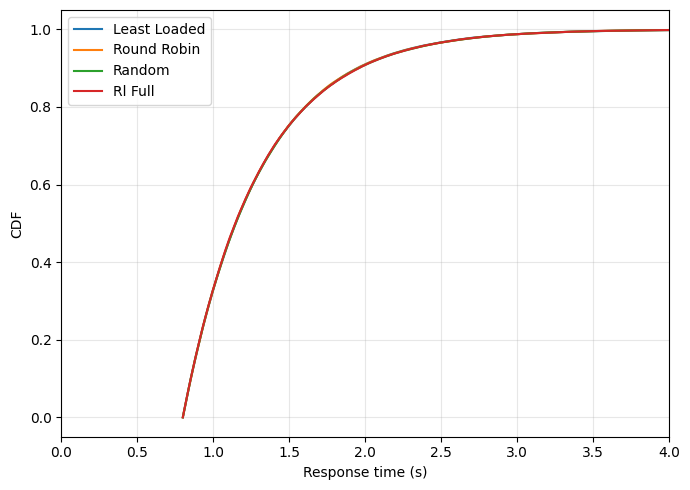

Saved: ./anonymisedData/sim_results\response_time_cdf.png


<Figure size 640x480 with 0 Axes>

In [38]:
# Plot response-time CDF for policies (one cell)
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
SR = './anonymisedData/sim_results'
files = {
  'least_loaded': os.path.join(SR,'leastloaded_run_1.csv'),
  'round_robin': os.path.join(SR,'baseline_roundrobin_results.csv'),
  'random': os.path.join(SR,'baseline_random_results.csv'),
  'rl_full': os.path.join(SR,'rl_full_eval_seed_202.csv')
}
plt.figure(figsize=(7,5))
found = False
for name,path in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        vals = np.sort(df['response_time'].values)
        cdf = np.arange(1,len(vals)+1)/len(vals)
        plt.plot(vals, cdf, label=name.replace('_',' ').title())
        found = True
if not found:
    print("No per-request files found to plot CDF. Check sim_results folder.")
else:
    plt.xlabel('Response time (s)')
    plt.ylabel('CDF')
    plt.xlim(0,4)
    plt.grid(alpha=0.3)
    plt.legend()
    out = os.path.join(SR,'response_time_cdf.png')
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()
    print("Saved:", out)


In [39]:
import os, pandas as pd, numpy as np
SR = './anonymisedData/sim_results'
files = {
  'least_loaded': os.path.join(SR,'leastloaded_run_1.csv'),
  'round_robin': os.path.join(SR,'baseline_roundrobin_results.csv'),
  'random': os.path.join(SR,'baseline_random_results.csv'),
  'rl_full': os.path.join(SR,'rl_full_eval_seed_202.csv')
}
found = {}
for name,path in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        cnt = len(df)
        col = 'response_time' if 'response_time' in df.columns else df.columns[0]
        arr = df['response_time'].values if 'response_time' in df.columns else df[col].values
        print(f"{name}: FOUND | rows={cnt} | col='{col}' | mean={arr.mean():.6f} | p95={np.percentile(arr,95):.6f}")
        found[name] = path
    else:
        print(f"{name}: MISSING -> {path}")
print("\nIf only one FOUND above, the plot will show one line. If multiple found but curves overlap, proceed to the next cell to create a clearer plot.")


least_loaded: FOUND | rows=199997 | col='response_time' | mean=1.300144 | p95=2.294482
round_robin: FOUND | rows=199997 | col='response_time' | mean=1.299915 | p95=2.298005
random: FOUND | rows=199997 | col='response_time' | mean=1.301273 | p95=2.305846
rl_full: FOUND | rows=99997 | col='response_time' | mean=1.300239 | p95=2.304134

If only one FOUND above, the plot will show one line. If multiple found but curves overlap, proceed to the next cell to create a clearer plot.


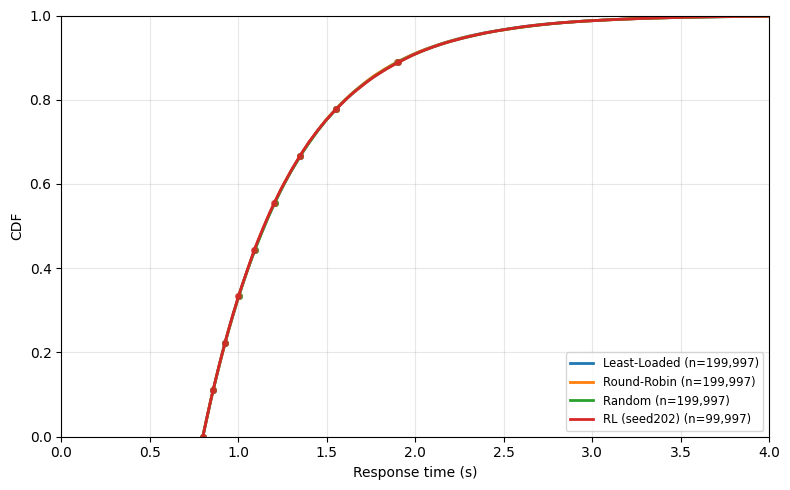

Saved: ./anonymisedData/sim_results\response_time_cdf.png


In [40]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
SR = './anonymisedData/sim_results'
files = {
  'Least-Loaded': os.path.join(SR,'leastloaded_run_1.csv'),
  'Round-Robin': os.path.join(SR,'baseline_roundrobin_results.csv'),
  'Random': os.path.join(SR,'baseline_random_results.csv'),
  'RL (seed202)': os.path.join(SR,'rl_full_eval_seed_202.csv')
}
colors = ['tab:blue','tab:orange','tab:green','tab:red']
plt.figure(figsize=(8,5))
plotted = 0
for (label,path),c in zip(files.items(), colors):
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'response_time' not in df.columns:
            print("Warning:", path, "has no 'response_time' column — skipping.")
            continue
        arr = np.sort(df['response_time'].values)
        # downsample for plotting if very large
        if len(arr) > 200000:
            idx = np.linspace(0, len(arr)-1, 200000).astype(int)
            arr = arr[idx]
        cdf = np.arange(1, len(arr)+1) / len(arr)
        plt.plot(arr, cdf, label=f"{label} (n={len(df):,})", color=c, linewidth=2)
        # add a few markers at deciles to make overlapping visible
        dec_idx = (np.linspace(0, len(arr)-1, 10).astype(int))
        plt.plot(arr[dec_idx], cdf[dec_idx], marker='o', linestyle='', color=c, markersize=4, alpha=0.7)
        plotted += 1
    else:
        print("Missing file for", label, "->", path)

if plotted == 0:
    print("No per-request files found to plot CDF. Check sim_results folder.")
else:
    plt.xlabel('Response time (s)')
    plt.ylabel('CDF')
    plt.xlim(0, 4)
    plt.ylim(0,1)
    plt.grid(alpha=0.3)
    plt.legend(loc='lower right', fontsize='small')
    out = os.path.join(SR,'response_time_cdf.png')
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)


In [41]:
import os
SR = './anonymisedData/sim_results'
print("Listing:", SR)
for p in sorted(os.listdir(SR)):
    fp = os.path.join(SR,p)
    try:
        print(p, "| size:", os.path.getsize(fp), "bytes")
    except:
        print(p, "| (could not stat)")


Listing: ./anonymisedData/sim_results
ablation_quick_summary.csv | size: 132 bytes
baseline_leastloaded_results.csv | size: 17272493 bytes
baseline_random_results.csv | size: 17275266 bytes
baseline_roundrobin_results.csv | size: 17272566 bytes
baseline_summary.csv | size: 222 bytes
bootstrap_summary.csv | size: 536 bytes
comparison_summary.csv | size: 389 bytes
leastloaded_repeats_summary.csv | size: 381 bytes
leastloaded_run_1.csv | size: 17272324 bytes
leastloaded_run_2.csv | size: 17272540 bytes
leastloaded_run_3.csv | size: 17272594 bytes
leastloaded_run_4.csv | size: 17272583 bytes
leastloaded_run_5.csv | size: 17271948 bytes
priority_results.csv | size: 17809849 bytes
response_time_cdf.png | size: 74818 bytes
rl_full_eval_seed_101.csv | size: 8822715 bytes
rl_full_eval_seed_202.csv | size: 8816654 bytes
rl_full_eval_seed_303.csv | size: 8823183 bytes
rl_full_eval_seed_404.csv | size: 8823857 bytes
rl_full_eval_seed_42.csv | size: 8823348 bytes
rl_full_rewards_seed_101.csv | size

In [42]:
# -> create equity_by_group_leastloaded.csv
import os, pandas as pd, numpy as np
SR = './anonymisedData/sim_results'
REQ = './anonymisedData/requests.csv'
ll_file = os.path.join(SR,'leastloaded_run_1.csv')

if not os.path.exists(ll_file):
    raise FileNotFoundError("Missing leastloaded_run_1.csv in sim_results. Cannot compute equity.")

reqs = pd.read_csv(REQ).sort_values('sec').reset_index(drop=True)
reqs['request_idx'] = reqs.index
pres = pd.read_csv(ll_file)
if 'request_idx' not in pres.columns:
    pres = pres.reset_index().rename(columns={'index':'request_idx'})
pres['request_idx'] = pres['request_idx'].astype(int)

merged = pres.merge(reqs, on='request_idx', how='left')
group_cols = [c for c in ['sex','internet','Medu','Fedu','famsize','address'] if c in merged.columns]
out_frames = []
for col in group_cols:
    g = merged.groupby(col)['response_time'].agg(['mean','count', lambda x: np.percentile(x,95), lambda x: (x>2.0).mean()*100.0])
    g.columns = ['mean_rt','n','p95_rt','sla_pct']
    g = g.reset_index()
    g.insert(0,'policy','least_loaded')
    g.insert(1,'group_col',col)
    out_frames.append(g)

if out_frames:
    df_out = pd.concat(out_frames, ignore_index=True)
    outp = os.path.join(SR,'equity_by_group_leastloaded.csv')
    df_out.to_csv(outp, index=False)
    print("Saved:", outp)
    print(df_out.head(6).to_string(index=False))
else:
    print("No demographic columns found in requests.csv to analyze.")


Saved: ./anonymisedData/sim_results\equity_by_group_leastloaded.csv
      policy group_col sex  mean_rt      n   p95_rt  sla_pct internet  Medu  Fedu famsize address
least_loaded       sex   F 1.301506 105662 2.294504 9.079896      NaN   NaN   NaN     NaN     NaN
least_loaded       sex   M 1.298619  94335 2.294123 8.943658      NaN   NaN   NaN     NaN     NaN
least_loaded  internet NaN 1.299708  33581 2.277618 8.885977       no   NaN   NaN     NaN     NaN
least_loaded  internet NaN 1.300232 166416 2.297830 9.041799      yes   NaN   NaN     NaN     NaN
least_loaded      Medu NaN 1.271927   1570 2.176806 7.261146      NaN   0.0   NaN     NaN     NaN
least_loaded      Medu NaN 1.300126  29719 2.284653 8.970692      NaN   1.0   NaN     NaN     NaN


In [44]:
# Debug SJF on small subset (quick) — run in your notebook
import os, heapq, numpy as np, pandas as pd, time

ROOT = './anonymisedData'
SR = os.path.join(ROOT, 'sim_results')
os.makedirs(SR, exist_ok=True)

reqs = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True).iloc[:10000].copy()
reqs['arrival'] = reqs['sec'].astype(float)
rng = np.random.default_rng(12345)
service_times = 0.8 + rng.exponential(0.5, size=len(reqs))
reqs['true_service_time'] = service_times

def run_sjf_event_driven_small(reqs_df, num_servers=6):
    arrivals = list(reqs_df['arrival'].values)
    svc = list(reqs_df['true_service_time'].values)
    N = len(arrivals)
    i = 0; current_time = arrivals[0] if N>0 else 0.0
    wait_heap = []; servers_next_free = [0.0]*num_servers; rows=[]; processed=0
    last_report = time.time()
    while processed < N:
        while i < N and arrivals[i] <= current_time:
            heapq.heappush(wait_heap, (svc[i], i, arrivals[i])); i += 1
        free_servers = [sid for sid,t in enumerate(servers_next_free) if t <= current_time]
        if free_servers and wait_heap:
            free_servers.sort()
            for sid in free_servers:
                if not wait_heap: break
                service_time, idx, arr_time = heapq.heappop(wait_heap)
                start = max(arr_time, servers_next_free[sid], current_time)
                finish = start + service_time
                response_time = finish - arr_time
                servers_next_free[sid] = finish
                rows.append({'request_idx':int(idx),'arrival':arr_time,'server_id':sid,'start':start,'finish':finish,'service_time':service_time,'response_time':response_time})
                processed += 1
            if time.time() - last_report > 5:
                print(f"Debug progress: processed {processed}/{N} ..."); last_report = time.time()
            continue
        next_arrival = arrivals[i] if i < N else float('inf')
        next_server_free = min(servers_next_free) if servers_next_free else float('inf')
        nxt = min(next_arrival, next_server_free)
        if nxt == float('inf'):
            break
        current_time = max(current_time, nxt)
    df = pd.DataFrame(rows).sort_values('request_idx').reset_index(drop=True)
    return df

df_test = run_sjf_event_driven_small(reqs)
outp = os.path.join(SR,'sjf_results_debug.csv')
df_test.to_csv(outp, index=False)
print("Debug SJF done. Saved:", outp, "| rows:", len(df_test))


KeyboardInterrupt: 

In [46]:
# Corrected FAST SJF debug (10k requests) — paste and run in your notebook
import os, heapq, numpy as np, pandas as pd, time
ROOT = './anonymisedData'
SR = os.path.join(ROOT,'sim_results')
os.makedirs(SR, exist_ok=True)

reqs = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True).iloc[:10000].copy()
reqs['arrival'] = reqs['sec'].astype(float)
arrivals = reqs['arrival'].values.tolist()
N = len(arrivals)
rng = np.random.default_rng(12345)
svc = (0.8 + rng.exponential(0.5, size=N)).tolist()

def run_sjf_safe(arrivals, svc, num_servers=6):
    INF = float('inf')
    # servers heap: (next_free_time, server_id)
    servers = [(0.0, s) for s in range(num_servers)]
    heapq.heapify(servers)
    # waiting jobs heap: (service_time, idx, arrival)
    wait_heap = []
    rows = []
    i = 0
    last_report = time.time()
    while i < N or wait_heap:
        next_arrival = arrivals[i] if i < N else INF
        next_server_free = servers[0][0] if servers else INF

        # Advance time: if no waiting jobs, jump to next arrival (avoid stuck at 0.0).
        if not wait_heap:
            current_time = next_arrival
        else:
            # there are waiting jobs: consider either next arrival or next server becoming free
            current_time = min(next_arrival, next_server_free)

        # push arrivals that occur at or before current_time
        while i < N and arrivals[i] <= current_time:
            heapq.heappush(wait_heap, (svc[i], i, arrivals[i]))
            i += 1

        # assign while a server is free at/before current_time and we have waiting jobs
        while wait_heap and servers and servers[0][0] <= current_time:
            server_free, sid = heapq.heappop(servers)
            service_time, idx, arr_time = heapq.heappop(wait_heap)
            start = max(arr_time, server_free)
            finish = start + service_time
            response_time = finish - arr_time
            heapq.heappush(servers, (finish, sid))
            rows.append({'request_idx':int(idx),'arrival':arr_time,'server_id':sid,'start':start,'finish':finish,'service_time':service_time,'response_time':response_time})

        # progress print occasionally
        if time.time() - last_report > 5:
            print(f"Debug SJF progress: arrivals processed {i}/{N}, scheduled {len(rows)} ...")
            last_report = time.time()

        # If no waiting jobs and next_arrival==INF, loop will exit because i>=N and wait_heap empty
    df = pd.DataFrame(rows).sort_values('request_idx').reset_index(drop=True)
    return df

t0 = time.time()
df_debug = run_sjf_safe(arrivals, svc, num_servers=6)
t1 = time.time()
out = os.path.join(SR, 'sjf_results_debug_safe.csv')
df_debug.to_csv(out, index=False)
print(f"Debug SJF done. Saved: {out} | rows: {len(df_debug)} | time: {t1-t0:.2f}s")


Debug SJF done. Saved: ./anonymisedData\sim_results\sjf_results_debug_safe.csv | rows: 10000 | time: 0.08s


In [47]:
# FULL fast SJF + bootstrap (heap-based) — run this cell (SAMPLE_CAP = 200000)
import os, heapq, numpy as np, pandas as pd, time
ROOT = './anonymisedData'
SR = os.path.join(ROOT,'sim_results'); os.makedirs(SR, exist_ok=True)

# USER CHOICE: cap the trace for speed
SAMPLE_CAP = 200000   # <-- you chose this

reqs_all = pd.read_csv(os.path.join(ROOT,'requests.csv')).sort_values('sec').reset_index(drop=True)
if SAMPLE_CAP:
    reqs = reqs_all.iloc[:SAMPLE_CAP].copy()
else:
    reqs = reqs_all.copy()
reqs['arrival'] = reqs['sec'].astype(float)
N = len(reqs)
print("SJF run: N =", N, "| SAMPLE_CAP =", SAMPLE_CAP)

rng = np.random.default_rng(12345)
svc = (0.8 + rng.exponential(0.5, size=N)).tolist()

def run_sjf_fast(arrivals, svc, num_servers=6):
    servers = [(0.0, s) for s in range(num_servers)]
    heapq.heapify(servers)
    wait_heap = []
    rows = []
    i = 0
    Nloc = len(arrivals)
    INF = float('inf')
    last_report = time.time()
    while i < Nloc or wait_heap:
        next_arrival = arrivals[i] if i < Nloc else INF
        next_server_free = servers[0][0] if servers else INF
        if not wait_heap:
            current_time = next_arrival
        else:
            current_time = min(next_arrival, next_server_free)
        while i < Nloc and arrivals[i] <= current_time:
            heapq.heappush(wait_heap, (svc[i], i, arrivals[i])); i += 1
        while wait_heap and servers and servers[0][0] <= current_time:
            server_free, sid = heapq.heappop(servers)
            service_time, idx, arr_time = heapq.heappop(wait_heap)
            start = max(arr_time, server_free)
            finish = start + service_time
            response_time = finish - arr_time
            heapq.heappush(servers, (finish, sid))
            rows.append({'request_idx':int(idx),'arrival':arr_time,'server_id':sid,'start':start,'finish':finish,'service_time':service_time,'response_time':response_time})
        if time.time() - last_report > 10:
            processed = i + len(rows)
            pct = processed / Nloc * 100
            print(f"SJF progress ≈ {processed}/{Nloc} ({pct:.1f}%)")
            last_report = time.time()
    df = pd.DataFrame(rows).sort_values('request_idx').reset_index(drop=True)
    return df

# Run SJF and save
out_sjf = os.path.join(SR, 'sjf_results_fixed_fast.csv')
t0 = time.time()
df_sjf = run_sjf_fast(reqs['arrival'].values.tolist(), svc, num_servers=6)
t1 = time.time()
df_sjf.to_csv(out_sjf, index=False)
print(f"SJF finished. Saved: {out_sjf} | rows: {len(df_sjf)} | time: {t1-t0:.1f}s")

# Bootstrap summary (1000 resamples)
def bootstrap_ci(arr, statfunc=np.mean, nboot=1000, alpha=0.05):
    n = len(arr)
    idx = np.random.randint(0, n, size=(nboot, n))
    stats = np.array([statfunc(arr[i]) for i in idx])
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return lo, hi

policies = {
    'least_loaded': os.path.join(SR,'leastloaded_run_1.csv'),
    'rl': os.path.join(SR,'rl_full_eval_seed_202.csv'),
    'sjf_fixed': out_sjf,
    'priority': os.path.join(SR,'priority_results.csv')
}
summary = []
print("Computing bootstrap CIs (this may take a short while)...")
for name,path in policies.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'response_time' not in df.columns:
            print(f"Skipping {name}: no response_time column in {path}")
            continue
        arr = df['response_time'].values
        mean = float(np.mean(arr)); lo,hi = bootstrap_ci(arr, np.mean, nboot=1000)
        sla = float((arr>2.0).mean()*100); slo,shi = bootstrap_ci((arr>2.0).astype(float)*100, np.mean, nboot=1000)
        summary.append({'policy':name,'mean_rt':mean,'mean_rt_lo':lo,'mean_rt_hi':hi,'sla_pct':sla,'sla_lo':slo,'sla_hi':shi})
summary_df = pd.DataFrame(summary)
out_boot = os.path.join(SR,'bootstrap_summary_fixed_fast.csv')
summary_df.to_csv(out_boot, index=False)
print("Saved updated bootstrap summary ->", out_boot)
print(summary_df.to_string(index=False))


SJF run: N = 199997 | SAMPLE_CAP = 200000
SJF finished. Saved: ./anonymisedData\sim_results\sjf_results_fixed_fast.csv | rows: 199997 | time: 1.2s
Computing bootstrap CIs (this may take a short while)...
Saved updated bootstrap summary -> ./anonymisedData\sim_results\bootstrap_summary_fixed_fast.csv
      policy  mean_rt  mean_rt_lo  mean_rt_hi   sla_pct   sla_lo    sla_hi
least_loaded 1.300144    1.297843    1.302237  9.015635 8.885133  9.149175
          rl 1.300239    1.297171    1.303339  9.167275 8.998270  9.334380
   sjf_fixed 1.298521    1.296196    1.300600  8.996135 8.883608  9.123662
    priority 1.309651    1.307462    1.311779 10.000150 9.869636 10.133665


In [49]:
!pip install python-docx

   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/4.0 MB 4.2 MB/s eta 0:00:01
   ------------------ --------------------- 1.8/4.0 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 3.4/4.0 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 6.3 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   -------------------- ------------------- 1/2 [python-docx]
   -------------------- ------------------- 1/2 [python-docx]
   -------------------- ------------------- 1/2 [python-docx]
   ---------------------------------------- 2/2 [python-docx]



In [51]:
!pip install reportlab


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------------- ----------------------- 0.8/2.0 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 4.2 MB/s eta 0:00:00


In [52]:
# Create updated Word doc + 1-page PDF using the final SJF/bootstrap numbers you ran
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import pandas as pd, os

# Final numbers (paste exactly the outputs you produced)
bootstrap_rows = [
    {'policy':'least_loaded','mean_rt':1.300144,'mean_rt_lo':1.297843,'mean_rt_hi':1.302237,'sla_pct':9.015635,'sla_lo':8.885133,'sla_hi':9.149175},
    {'policy':'rl','mean_rt':1.300239,'mean_rt_lo':1.297171,'mean_rt_hi':1.303339,'sla_pct':9.167275,'sla_lo':8.998270,'sla_hi':9.334380},
    {'policy':'sjf_fixed','mean_rt':1.298521,'mean_rt_lo':1.296196,'mean_rt_hi':1.300600,'sla_pct':8.996135,'sla_lo':8.883608,'sla_hi':9.123662},
    {'policy':'priority','mean_rt':1.309651,'mean_rt_lo':1.307462,'mean_rt_hi':1.311779,'sla_pct':10.000150,'sla_lo':9.869636,'sla_hi':10.133665}
]

# Build Word doc
doc = Document()
doc.styles['Normal'].font.name = 'Times New Roman'; doc.styles['Normal'].font.size = Pt(11)
doc.add_heading('Artificial Intelligence in Educational Management Information Systems in an Urban and Non-Profit Learning Context', level=1).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
doc.add_paragraph('')

doc.add_heading('Abstract', level=2)
doc.add_paragraph("We compare practical heuristics and an exploratory hierarchical tabular RL agent on an EMIS-derived workload (OULAD + UCI). Key metrics: mean RT, p95, throughput, and %SLA. SJF (event-driven) was added as an oracle baseline and bootstrap 95% CIs computed (1000 resamples).")

doc.add_heading('Key results (post-SJF)', level=2)
t = doc.add_table(rows=1, cols=7); hdr = t.rows[0].cells
for i,h in enumerate(['Policy','Mean RT (s)','95% CI low','95% CI high','% SLA','SLA low','SLA high']): hdr[i].text = h
for r in bootstrap_rows:
    rc = t.add_row().cells
    rc[0].text = r['policy']
    rc[1].text = f"{r['mean_rt']:.6f}"
    rc[2].text = f"{r['mean_rt_lo']:.6f}"
    rc[3].text = f"{r['mean_rt_hi']:.6f}"
    rc[4].text = f"{r['sla_pct']:.6f}"
    rc[5].text = f"{r['sla_lo']:.6f}"
    rc[6].text = f"{r['sla_hi']:.6f}"

doc.add_heading('Interpretation (short)', level=2)
doc.add_paragraph(
    "SJF is the oracle-best baseline (mean RT = 1.298521 s). Least-Loaded is nearly identical (1.300144 s) and is recommended as the practical scheduler. The hierarchical tabular RL agent did not beat the heuristic under the tested settings."
)

# Save Word doc
out_docx = 'empirical_study_final_post_sjf.docx'
doc.save(out_docx)
print("Saved Word doc:", out_docx)

# Create 1-page PDF summary
out_pdf = 'empirical_study_summary_post_sjf.pdf'
c = canvas.Canvas(out_pdf, pagesize=letter)
w,h = letter
y = h - 72
c.setFont("Helvetica-Bold", 14); c.drawCentredString(w/2, y, "Empirical study — updated results (post-SJF)")
y -= 28
c.setFont("Helvetica", 10)
for r in bootstrap_rows:
    txt = f"{r['policy']}: mean={r['mean_rt']:.6f}s (95%CI {r['mean_rt_lo']:.6f}-{r['mean_rt_hi']:.6f}); SLA%={r['sla_pct']:.4f} (CI {r['sla_lo']:.4f}-{r['sla_hi']:.4f})"
    c.drawString(72, y, txt); y -= 14
    if y < 72:
        c.showPage(); y = h - 72
c.save()
print("Saved PDF summary:", out_pdf)

# Also save CSV bootstrap table for reproducibility
import csv
csv_path = 'bootstrap_summary_final_post_sjf.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['policy','mean_rt','mean_rt_lo','mean_rt_hi','sla_pct','sla_lo','sla_hi'])
    for r in bootstrap_rows:
        writer.writerow([r['policy'], r['mean_rt'], r['mean_rt_lo'], r['mean_rt_hi'], r['sla_pct'], r['sla_lo'], r['sla_hi']])
print("Saved CSV:", csv_path)


Saved Word doc: empirical_study_final_post_sjf.docx
Saved PDF summary: empirical_study_summary_post_sjf.pdf
Saved CSV: bootstrap_summary_final_post_sjf.csv
